In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from pandasql import sqldf
import sklearn 
import mlxtend 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
pysqldf = lambda q: sqldf(q, globals())


In [2]:
Analysis_Framework = pd.read_csv("titanic-train.csv")
dataset_titanic = pd.DataFrame(Analysis_Framework)

Dictionnaire des colones: <br>
- Label    Intitulé <br>
- survival    Survival (0 = No; 1 = Yes) <br>
- pclass    Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd) <br>
- name    Name <br>
- sex    Sex <br>
- age    Age <br>
- sibsp    Nombre de frere et soeur/ conjoint à bord <br>
- parch    Nombre de parent/d'enfants a bord <br>
- ticket    Ticket Number <br>
- fare    Passenger Fare (tarif) <br>
- cabin    Cabin <br>
- embarked    Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton) <br>

In [3]:
dataset_titanic.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#pour regarder les types de colones
dataset_titanic.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

note: sexe est un string donc on convertit en entier: 0 pour les males, et 1 pour les femelles

In [5]:

dataset_titanic['Sex'] = dataset_titanic['Sex'].replace('male',0)
dataset_titanic['Sex'] = dataset_titanic['Sex'].replace('female',1)

verification des nan ou remplacements

In [6]:
dataset_titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
#remarque la colonne Age possède 177 NaN, choix de les remplacer par la median
dataset_titanic['Age'].fillna(dataset_titanic['Age'].median(), inplace = True)

#Il n'y a que 2 embarked NaN, donc je supprime ces deux lignes
index= dataset_titanic[ (dataset_titanic['Embarked']!="S") & (dataset_titanic['Embarked']!="C") & (dataset_titanic['Embarked']!="Q")  ].index
dataset_titanic.drop(index,inplace=True)
#la colonne Cabin possède beaucoup de NaN je choisis donc de la supprimer
dataset_titanic=dataset_titanic.drop('Cabin', axis=1)


#Suppression des colonnes name et ticket 
# car ce ne sont pas des valeurs numériques et je ne vais pas m'en servir pour la suite
dataset_titanic=dataset_titanic.drop(['Name'],axis=1)
dataset_titanic=dataset_titanic.drop(['Ticket'],axis=1)

display(dataset_titanic)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,0,22.0,1,0,7.2500,S
1,2,1,1,1,38.0,1,0,71.2833,C
2,3,1,3,1,26.0,0,0,7.9250,S
3,4,1,1,1,35.0,1,0,53.1000,S
4,5,0,3,0,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,27.0,0,0,13.0000,S
887,888,1,1,1,19.0,0,0,30.0000,S
888,889,0,3,1,28.0,1,2,23.4500,S
889,890,1,1,0,26.0,0,0,30.0000,C


Je decide de numériser la colone Embarked, <br>
tel que C=1, Q=2 et S=3

In [8]:
dataset_titanic['Embarked'] = dataset_titanic['Embarked'].replace('C',1)
dataset_titanic['Embarked'] = dataset_titanic['Embarked'].replace('Q',2)
dataset_titanic['Embarked'] = dataset_titanic['Embarked'].replace('S',3)

display(dataset_titanic)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,0,22.0,1,0,7.2500,3
1,2,1,1,1,38.0,1,0,71.2833,1
2,3,1,3,1,26.0,0,0,7.9250,3
3,4,1,1,1,35.0,1,0,53.1000,3
4,5,0,3,0,35.0,0,0,8.0500,3
...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,27.0,0,0,13.0000,3
887,888,1,1,1,19.0,0,0,30.0000,3
888,889,0,3,1,28.0,1,2,23.4500,3
889,890,1,1,0,26.0,0,0,30.0000,1


# FEATURES SELECTION

## Methode Filter

#### Regression linéaire simple entre chaque facteur et la sortie
2 étapes: <br>
  -  E[(X[:, i] - mean(X[:, i])) * (y - mean(y))] / (std(X[:, i]) * std(y)) <br>
    -> std renvoie l'écart type du vecteur placé en paramètre
  -  puis converstion du résultat en score pour chaque facteurs

In [9]:
#on regarde les corrélations pour chaque colone du dataset avec la sortie
#@parameter: la matrice de feature, le vecteur de sortie
#@return: le premier tableau est le score de corrélation avec la sortie, le deuxième est les P-values associés
feature_selection_by_regression =sklearn.feature_selection.f_regression(dataset_titanic.drop(['Survived'],axis=1),dataset_titanic['Survived'])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0 1 2 3 4 5 6 7]


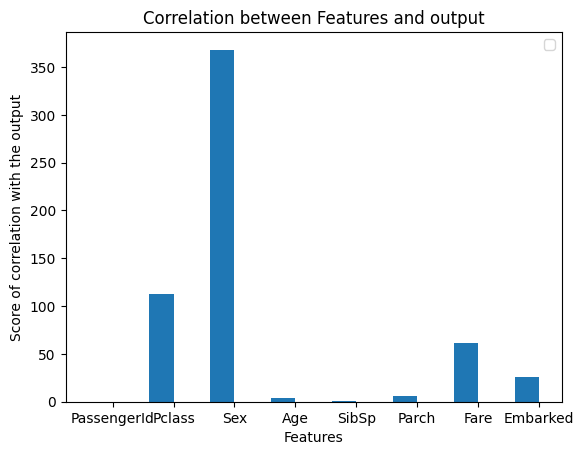

In [10]:
X = dataset_titanic.drop('Survived',axis=1).columns.values

X_axis = np.arange(len(X))
print(X_axis)
plt.bar(X_axis - 0.2, feature_selection_by_regression[0], 0.4)
  
plt.xticks(X_axis, X)
plt.xlabel("Features")
plt.ylabel("Score of correlation with the output")
plt.title("Correlation between Features and output")
plt.legend()

Ainsi on remarque que les Facteurs qui sont le plus en corrélation avec la sortie (Survived) sont "Sex", "PClass", "Fare" puis "Embarked". <br>
Les autres ont des corrélations assez faibles.

## Methode Wrapper

Cette méthode va regarder en premier lieu la corrélation de chaque features entre elles mais aussi avec la sortie. <br>
- Forward:
- Retourne dans l'odre un vecteur en ajoutant à chaque nouvelle itération i la ième feature avec la plus grosse corrélation soit avec une autre feature soit avec la sortie <br>

- Backward:
- Retourne dans l'odre un vecteur en enlevant à chaque nouvelle itération i la ième feature avec la plus petite corrélation soit avec une autre feature soit avec la sortie <br>

In [11]:
# import 
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression

In [18]:
#On definit une sequence de selection de type forward (on part d'un vecteur nul)
#@parametre: methode d'apprentissage, nombre de facteur souhaiter à la fin, 
#cette méthode va selectionner executer une selection de type wrapper sur les feature
#tout en appliquant à chaque itération un algo de régression linéaire avec pour performance évaluée la mse des feature selectionnées
sffs = SFS(LinearRegression(),
           k_features=len(dataset_titanic.drop('Survived',axis=1).columns.values),
           forward=True,
           floating=True,
           scoring = 'r2', #mse normalisé 
           cv = 0)
#entrainement du modèle et filtre sur notre dataset 
feature_names=dataset_titanic.drop('Survived',axis=1).columns.values
sffs.fit(dataset_titanic.drop(['Survived'],axis=1),dataset_titanic['Survived'])

#Creation d'un dataframe pour les résultats 
df_SFFS_results = pd.DataFrame(sffs.subsets_).transpose()
df_SFFS_results
#la sortie nous montre pour chaque itération les features selectionnées ainsi que la performance du modele de ml entrainer (ici regression
# linéaire)


,feature_idx,cv_scores,avg_score,feature_names
1,"(2,)",[0.29331422075256586],0.293314,"(Sex,)"
2,"(1, 2)",[0.36544219980224724],0.365442,"(Pclass, Sex)"
3,"(1, 2, 3)",[0.3812050648461408],0.381205,"(Pclass, Sex, Age)"
4,"(1, 2, 3, 4)",[0.39110612511710274],0.391106,"(Pclass, Sex, Age, SibSp)"
5,"(1, 2, 3, 4, 7)",[0.39470533565035015],0.394705,"(Pclass, Sex, Age, SibSp, Embarked)"
6,"(1, 2, 3, 4, 5, 7)",[0.39508385140114366],0.395084,"(Pclass, Sex, Age, SibSp, Parch, Embarked)"
7,"(1, 2, 3, 4, 5, 6, 7)",[0.3955990677367276],0.395599,"(Pclass, Sex, Age, SibSp, Parch, Fare, Embarked)"
8,"(0, 1, 2, 3, 4, 5, 6, 7)",[0.3956341368440378],0.395634,"(PassengerId, Pclass, Sex, Age, SibSp, Parch, ..."


On remarque que le score augmente beaucoup lorsque l'on ajoute le facteur Pclass ainsi que l'Age.
<br><br>
Cependant par la suite, l'augmentation du score est beaucoup plus faible lors de l'ajout des autres facteurs <br>
Cela concorde avec notre premiere selection, les features Sex, PClass et Age sont les plus importantes en termes de corrélation avec la sortie. 
<br><br>
Ainsi on aurait pu réduire le nombre de facteur dans le vecteur final à 3 ou 4
<br> <br>
D'autres part on remarque que l'ordre d'ajout des features au vecteur ne correspond pas à l'odre des features avec la méthode filter. <br>
Cela s'explique par le fait que la méthode filter ne regarde que la corrélation entre les features et la sortie.<br>
Tandis que la méthode wrapper regarder également les corrélations entre chaque feature. 
<br><br>
Ainsi, celon les méthodes choisies, les sorties et donc les décisions pour le choix des features ne seront pas les mêmes. 
<br>
Question: Comment choisir la méthode de selection?

## Methode Embeded

In [13]:
sel = SelectFromModel(RandomForestClassifier())
sel.fit(dataset_titanic.drop(['Survived'],axis=1), dataset_titanic['Survived'])
selected_feat= dataset_titanic.drop(['Survived'],axis=1).columns[(sel.get_support())]
print(selected_feat)


Index(['PassengerId', 'Sex', 'Age', 'Fare'], dtype='object')


On remarque que l'on a une fois de plus des résultats différents

## Comparaison avec la matrice de corrélation

<AxesSubplot: >

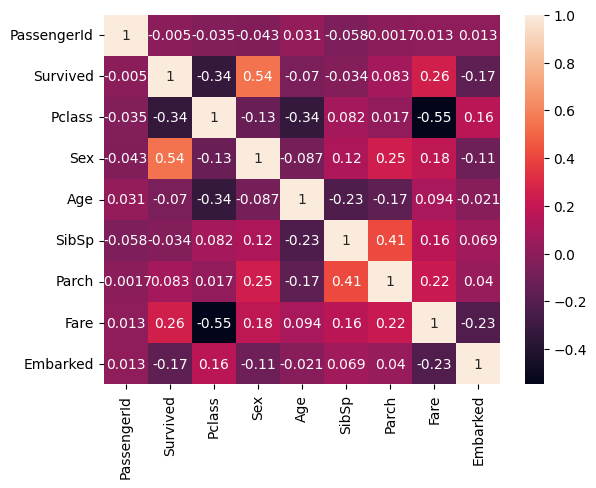

In [14]:
#on regarde les corrélations entre chaque colone du dataset, 
corrMatrix = dataset_titanic.corr()
sn.heatmap(corrMatrix, annot=True)

On remarque que les fortes corrélations sont entre les colones: Survived-Pclass, Survived-Sex, Survived-Fare et Survived-Embarked pour la sortie (Survived), mais aussi entre Pclass-Age, Fare-Pclass, SibSp-Parch,Embarked-Fare, Fare-Parch,Fare-SibSp.

Ainsi en comparant la matrice de corrélations ci dessus avec les résultats obtenu lors des différentes méthodes de selection. <br> <br>
On remarque que les features celon leur correlation ressortent en fonction de la méthode utilisée. <br> <br>
Par exemple, les fortes corrélations avec la sortie ressortiront plus avec la méthode filter. <br> <br>
Tandis que de fortes correlations entre features peuvent ressortir avant même certaines forte corrélation avec la sortie lors de méthodes wrapper ou même embeded

## Conclusion

Ainsi, chaque méthode fait ressortir des features différentes. <br>
Donc pour une selection il pourrait être intérressant d'utiliser plusieurs méthodes et de choisir les features dans celles retournées par ces dernières. <br> <br>
Cependant, on peut se demander dans dans quels cas utiliser quelles methodes de selection...

Ainsi pour ce dataset, on pourrait garder un premier modèle avec les features Sex, Pclass, Fare ainsi que Age. <br>
Une fois ce modèle entrainer il pourra être intérressant de rajouter la feature SibSp et voir si la performance du modèle augmente avec cet ajout ou pas.